<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

In this [project](https://www.coursera.org/projects/fine-tune-bert-tensorflow/), you will learn how to fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [26]:
!nvidia-smi

Mon May 20 13:38:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              29W /  70W |   8367MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install TensorFlow and TensorFlow Model Garden

In [27]:
import tensorflow as tf
print(tf.version.VERSION)

2.15.0


In [28]:
# !pip install -q tensorflow==2.3.0

In [29]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [30]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done


## Restart the Runtime

**Note**
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

In [31]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [32]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [34]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression = 'zip' , low_memory = False)
df.shape

(1306122, 3)

<Axes: title={'center': 'target distribution'}, ylabel='Frequency'>

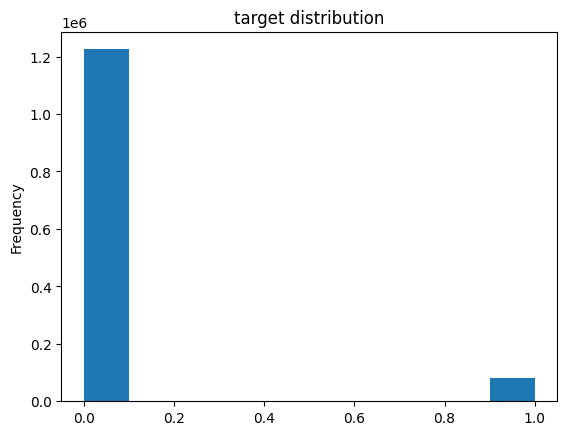

In [35]:
df.target.plot(kind = 'hist' , title = 'target distribution')

In [36]:
train_df , remaining = train_test_split(df , train_size = 0.0075 , random_state = 42 , stratify= df.target.values)
valid_df , _ = train_test_split(remaining , train_size = 0.00075, random_state = 42 , stratify = remaining.target.values)
train_df.shape , valid_df.shape

((9795, 3), (972, 3))

In [37]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values , train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values , valid_df.target.values))

  for text , label in train_data.take(1):
    print(text)
    print(label)



tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [38]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0,1]     # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2" , trainable = True)


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file , do_lower_case)



In [39]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [40]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [41]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0 , example , label_list , max_seq_length , tokenizer)
  return (feature.input_ids , feature.input_mask , feature.segment_ids , feature.label_id)


You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [42]:
def to_feature_map(text, label):
  input_ids , input_mask , segment_ids , label_id = tf.py_function(to_feature , inp = [text , label] ,
                                                                   Tout = [tf.int32 , tf.int32 , tf.int32 , tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
  }

  return (x , label_id)

In [43]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32 , drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))



  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32 , drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))



The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [44]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [45]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [46]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,) , dtype = tf.int32 , name = 'input_word_ids')

  input_mask = tf.keras.layers.Input(shape=(max_seq_length , ) , dtype = tf.int32 , name = "input_mask")

  input_type_ids = tf.keras.layers.Input(shape = (max_seq_length,) ,dtype = tf.int32 , name = "input_type_ids")

  pooled_output , sequence_output = bert_layer([input_word_ids , input_mask , input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)

  output = tf.keras.layers.Dense(1 , activation = "sigmoid" , name = "output")(drop)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)
  return model




In [47]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5) ,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

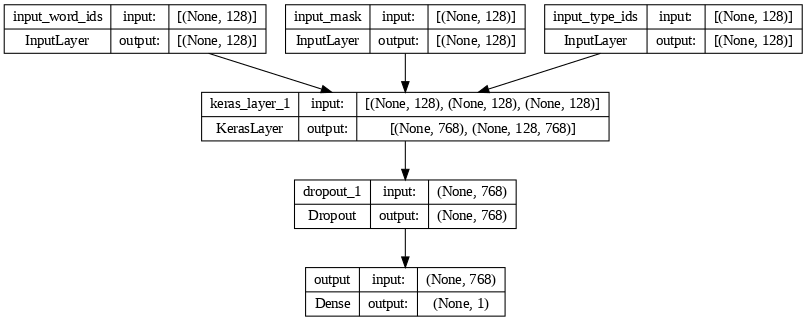

In [48]:
tf.keras.utils.plot_model(model = model , show_shapes = True , dpi = 76)

In [25]:
# Train model
epochs = 4
history = model.fit(train_data ,
                    validation_data = valid_data ,
                    epochs = epochs ,
                    verbose = 1)


Epoch 1/4
306/306 [==============================] - 304s 838ms/step - loss: 0.1694 - binary_accuracy: 0.9388 - val_loss: 0.1174 - val_binary_accuracy: 0.9563
Epoch 2/4
306/306 [==============================] - 252s 821ms/step - loss: 0.0996 - binary_accuracy: 0.9604 - val_loss: 0.1236 - val_binary_accuracy: 0.9583
Epoch 3/4
306/306 [==============================] - 252s 820ms/step - loss: 0.0513 - binary_accuracy: 0.9801 - val_loss: 0.1819 - val_binary_accuracy: 0.9542
Epoch 4/4
306/306 [==============================] - 251s 815ms/step - loss: 0.0249 - binary_accuracy: 0.9914 - val_loss: 0.2319 - val_binary_accuracy: 0.9573


In [49]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

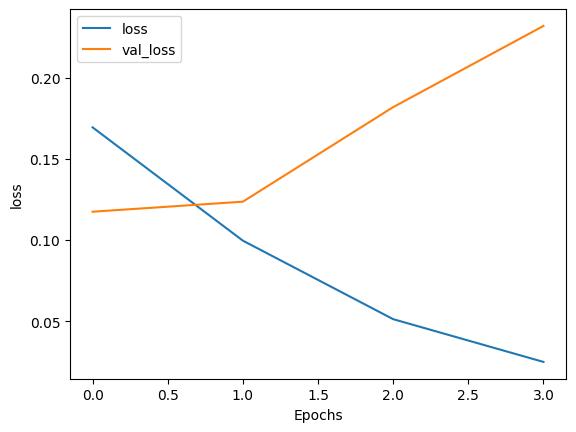

In [50]:
plot_graphs(history , 'loss')

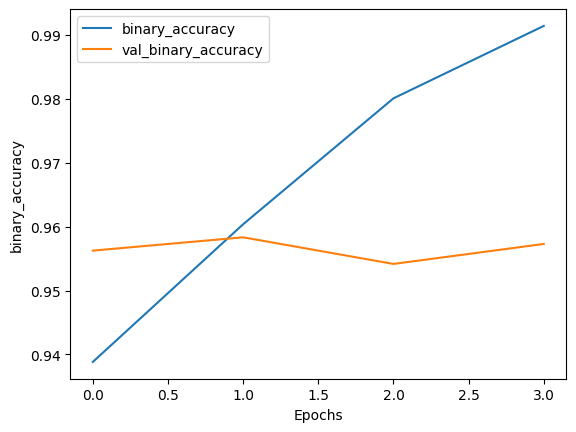

In [51]:
plot_graphs(history , 'binary_accuracy')

In [52]:
sample_example = []
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test.data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5 # Specify between 0 and 1.
['Insincere' if pred >= threshold else 'Sincere' for pred in preds ]

SyntaxError: invalid syntax (<ipython-input-52-da9fc535b155>, line 5)